In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpi4py import MPI

from IPython.display import display, clear_output
import gc
import sys

print("Python executable:", sys.executable)
print("Python version:", sys.version)
import matplotlib
import matplotlib.pyplot as plt

print(matplotlib.__version__)
import math

import numpy as np

Python executable: /usr/bin/python3
Python version: 3.10.12 (main, Jan 17 2025, 14:35:34) [GCC 11.4.0]
3.5.1


In [2]:
TOTAL_TIME = 0.1
VERBOSE1=True
VERBOSE2=False

Cs=math.sqrt(1/3)
D=1e-3 #m
L=1 #m

D_nd=50 #100

Yn=D_nd #+1
Xn=200 #int(Yn*L/D)

if(VERBOSE1): print("Ny: {0}".format(Yn))
if(VERBOSE1): print("Nx: {0}".format(Xn))

dx=D/D_nd #old->5*10**(-5)
dy = dx
if(VERBOSE1): print("dx: {0}".format(dx))
#relaxation time tau, should be > 0,5
tau=0.6

dP=1e-2 #Pa
rho_0=1e3 #kg/m^3
p_in=1/3
p_out=p_in-dP
roh_in=p_in/Cs**2
roh_out=p_out/Cs**2
dRho=dP/Cs**2


if(VERBOSE1): 
    print("p_in: {0}".format(p_in))
    print("p_out: {0}".format(p_out))
    print("roh_in: {0}".format(roh_in))
    print("roh_out: {0}".format(roh_out))

nu=2.9e-6 #m^2/s 
dt=Cs**2*(tau-0.5)*(dx**2/nu)

nu_ = Cs**2*(tau-0.5)*(dx**2) * dx
dt_=Cs**2*(tau-0.5)*(dx**2/nu_)

Cs_ = math.sqrt(1/3*(dx**2/dt**2))
if(VERBOSE1): print("dt: {0}".format(dt))

#Poiseuille centerline (max) velocity
U=1/8*(rho_0/nu)*(dP/L)*(D**2)
#U=1.25

Re=D*U/nu
Ma=U/Cs 
Kn=U*D/nu
if(VERBOSE1): 
    print("U: {0}".format(U))
    print("Re: {0}".format(Re))
    print("Ma: {0}".format(Ma))
    print("Kn: {0}".format(Kn))

#we need Cl, Croh, Ct

# 1. Conversion factor Cl for length
Cl=dx #freely chosen
dx_nd=dx/Cl
if(VERBOSE1): 
    print("Cl: {0}".format(Cl))
    print("dx_nd: {0}".format(dx_nd))

#2. Conversion factor Croh for density
Croh=rho_0
roh_nd = rho_0/Croh
if(VERBOSE1): 
    print("Croh: {0}".format(Croh))
    print("roh_nd: {0}".format(roh_nd))

#3. Conversion factor Ct for time
Ct=dt
dt_nd = dt/Ct
if(VERBOSE1): 
    print("Ct: {0}".format(Ct))
    print("dt_nd: {0}".format(dt_nd))

#4. Conversion factor Cu for velocity
Cu=Cl/Ct
U_nd = U/Cu #-> limit U_nd=0.1
U_nd=0.1

if(VERBOSE1): 
    print("Cu: {0}".format(Cu))
    print("U_nd: {0}".format(U_nd))

#5. Conversion factor CF for Force
CF=Croh*Cl**4*Ct**(-2)
if(VERBOSE1): print("CF: {0}".format(CF))

#6. Conversion factor Cf for frequency
Cf=1/Ct
if(VERBOSE1): print("Cf: {0}".format(Cf))

#change nu_nd in order to achieve U_nd=0,1
nu_nd=((D_nd*U_nd)/(D*U))*nu
if(VERBOSE1): print("nu_nd: {0}".format(nu_nd))

tau_nd=(nu_nd/Cs**2)+1./2
if(VERBOSE1): print("tau_nd: {0}".format(tau_nd))
omega = dt/tau
if(VERBOSE1): print("omega: {0}".format(omega))
omega_nd = dt_nd/tau_nd
if(VERBOSE1): print("omega_nd: {0}".format(omega_nd))

Ny: 50
Nx: 200
dx: 2e-05
p_in: 0.3333333333333333
p_out: 0.3233333333333333
roh_in: 1.0
roh_out: 0.97
dt: 4.597701149425287e-06
U: 0.43103448275862066
Re: 148.63258026159332
Ma: 0.7465736239521022
Kn: 148.63258026159332
Cl: 2e-05
dx_nd: 1.0
Croh: 1000.0
roh_nd: 1.0
Ct: 4.597701149425287e-06
dt_nd: 1.0
Cu: 4.350000000000001
U_nd: 0.1
CF: 7.569000000000005e-06
Cf: 217500.00000000003
nu_nd: 0.03364
tau_nd: 0.60092
omega: 7.662835249042145e-06
omega_nd: 1.6641150236304334


In [3]:
iteration = 0

columns_to_select = [1, 2, 3, 10, 20, 50, Xn]
_roh_at_points_top = []
_roh_at_points_mid = []
_roh_at_points_bottom = []

#discrete velocity channels for D2Q9
discrete_velocities = np.array([[0, 0],     # i=0
                      [1, 0],               # i=1
                      [0, 1],               # i=2
                      [-1, 0],              # i=3
                      [0, -1],              # i=4
                      [1, 1],               # i=5
                      [-1, 1],              # i=6
                      [-1, -1],             # i=7
                      [1, -1]])             # i=8

if(VERBOSE1): print("Discrete velocities: {0}".format(discrete_velocities))
channel_indices = [0,1,2,3,4,5,6,7,8] #channel
antichannel_indices =[0,3,4,1,2,7,8,5,6] #anti-channel
index_mapping_top = np.array([False, False, True, False, False, True, True, False, False])
index_mapping_bottom = np.array([False, False, False, False, True, False, False, True, True])

#weights
weights = np.array([4/9,1/9,1/9,1/9,1/9,1/36,1/36,1/36,1/36])
if(VERBOSE1): print("Weights: {0}".format(weights))

Discrete velocities: [[ 0  0]
 [ 1  0]
 [ 0  1]
 [-1  0]
 [ 0 -1]
 [ 1  1]
 [-1  1]
 [-1 -1]
 [ 1 -1]]
Weights: [0.44444444 0.11111111 0.11111111 0.11111111 0.11111111 0.02777778
 0.02777778 0.02777778 0.02777778]


In [4]:
#equilibrium distribution function feq(0->8)
def f_eq_2D(_rho, _u_ckl):
    global discrete_velocities, weights
    
    _u_ckl_dot = np.dot(discrete_velocities, _u_ckl) 
    _u_ckl_product = np.einsum('ki,ki->i', _u_ckl, _u_ckl)

    _u_ckl_product_reshaped = _u_ckl_product.reshape(1, *(_u_ckl_product.shape))
    _ones = np.ones(_u_ckl_dot.shape)

    _rho_reshaped = _rho.reshape(1, *(_rho.shape))
    weights_reshaped = weights.reshape((9, 1)) * np.ones(_rho.shape)
    factors = weights_reshaped * _rho_reshaped

    f_eq = factors * (
        #_ones + 3. * _u_ckl_dot / Cs**2 + (9. / 2.) * _u_ckl_dot**2 / Cs**4 - (3. / 2.) * _u_ckl_product_reshaped / Cs**2
        _ones + _u_ckl_dot / Cs**2 + (1/2.) * _u_ckl_dot**2 / Cs**4 - (1/2.) * _u_ckl_product_reshaped / Cs**2
    )

    del _u_ckl_dot
    del _u_ckl_product
    del _u_ckl_product_reshaped
    del _ones
    del _rho_reshaped
    del weights_reshaped
    del factors
    gc.collect()

    return f_eq


def f_eq_3D(_rho, _u_ckl):
    global discrete_velocities, weights

    _u_ckl_dot = np.einsum('hk,kji->hji', discrete_velocities, _u_ckl) #(9,2) * (2,101,101002)
    _u_ckl_product = np.einsum('kji,kji->ji', _u_ckl, _u_ckl)
    _u_ckl_product_reshaped = _u_ckl_product.reshape(1, *(_u_ckl_product.shape))
    _ones = np.ones(_u_ckl_dot.shape)

    _rho_reshaped = _rho.reshape(1, *(_rho.shape))
    weights_reshaped = weights.reshape((9, 1, 1)) * np.ones(_rho.shape)
    factors = weights_reshaped * _rho_reshaped

    #Part_2_BTE_to_LBM, BTE3
    #feq = factors * (
    #    _ones + 3. * _u_ckl_dot / Cs**2 + (9. / 2.) * _u_ckl_dot**2 / Cs**4 - (3. / 2.) * _u_ckl_product_reshaped / Cs**2
    #)

    #BGK formula, Kruger pp67
    f_eq = factors * (
        _ones + _u_ckl_dot / Cs**2 + (1/2.) * _u_ckl_dot**2 / Cs**4 - (1/2.) * _u_ckl_product_reshaped / Cs**2
    )

    del _u_ckl_dot
    del _u_ckl_product
    del _u_ckl_product_reshaped
    del _ones
    del _rho_reshaped
    del weights_reshaped
    del factors
    gc.collect()

    return f_eq


#roll the lattice based on the discrete velocities
def streamLattice(_ltc):
    global discrete_velocities, weights
    #Send to the right, receive from the left
    #comm.Sendrecv(_ltc[:, -2, :], (rank+1)%size, recbuf=_ltc[:, 0, :], source=(rank-1)%size)
    #Send to the left, receive from the right
    #comm.Sendrecv(_ltc[:, 1, :], (rank-1)%size, recbuf=_ltc[:, -1, :], source=(rank+1)%size)

    tmpLtc = [np.roll(np.roll(_ltc[direction, :, :], shift=dy, axis=0), shift=dx, axis=1) for direction, (dx, dy) in enumerate(discrete_velocities)]
    shifted_lattice = np.stack(tmpLtc, axis=0) 

    del tmpLtc
    gc.collect()
    
    return shifted_lattice


#update the first 2 moments (density, current density, _u_ckl)
def updateMoments(_ltc):
    global discrete_velocities, weights
    
    # density:
    _roh = np.sum(_ltc, axis=0)

    # current density:
    _current_density =  np.einsum('ki,ijl->kjl', discrete_velocities.T, _ltc)

    # average velocity:
    _u_ckl = _current_density / _roh

    del _current_density
    gc.collect()    

    return _roh, _u_ckl


channel_indices = [0,1,2,3,4,5,6,7,8] #channel
antichannel_indices =[0,3,4,1,2,7,8,5,6] #anti-channel
index_mapping_top = np.array([False, False, True, False, False, True, True, False, False])
index_mapping_bottom = np.array([False, False, False, False, True, False, False, True, True])    


#apply bounce-back conditions on upper and lower boundaries of pipe
def bounceBackTopBottom0(_ltc, _ltc_pre, _index_mapping_top, _index_mapping_bottom):
    global channel_indices, antichannel_indices
    
    # row indices for top and bottom boundaries
    top_boundary = Yn
    bottom_boundary = 1

    # swaps on the top boundary
    for i, swap_needed in enumerate(_index_mapping_top):
        if swap_needed:
            _ltc[channel_indices[i], top_boundary, :] = _ltc_pre[antichannel_indices[i], top_boundary, :]
    
    # swaps on the bottom boundary
    for i, swap_needed in enumerate(_index_mapping_bottom):
        if swap_needed:
            _ltc[channel_indices[i], bottom_boundary, :] = _ltc_pre[antichannel_indices[i], bottom_boundary, :]

    return _ltc


def bounceBackTopBottom1(f, nx, ny):
    '''Performs the bounce back step
    
    Arguements
    -----------
    f: np.array (nx, ny, 9)
        probability density function
    nx: int
        number of grid points in x direction
    ny: int
        number of grid points in y direction
    
    Returns
    ---------
    f: np.array (nx, ny, 9)
        probability density function after the bounce back step
    '''
    top_boundary = ny
    bottom_boundary = 1
     
    # rigid lower wall 
    f[2, 1, 1 : nx + 1] = f[4, 0, 1 : nx + 1]
    f[5, 1, 1 : nx + 1] = np.roll(f[7, 0, 1 : nx + 1], 1)
    f[6, 1, 1 : nx + 1] = np.roll(f[8, 0, 1 : nx + 1], -1)
    
    # rigid upper wall
    f[4, ny, 1 : nx + 1] = f[2, ny + 1, 1 : nx + 1]
    f[7, ny, 1 : nx + 1] = np.roll(f[5, ny + 1, 1 : nx + 1], -1)
    f[8, ny, 1 : nx + 1] = np.roll(f[6, ny + 1, 1 : nx + 1], 1)

    return f    


#calulate boundary nodes X(0) and X(N+1) for periodic BC with presssure difference
def calcPeriodicBC(_roh_N, _u_cNl, _roh_in, _roh_1, _u_c1l, _roh_out, _ltc_prestream): 

    f_eq_in = f_eq_2D(_roh_in, _u_cNl)
    fi_xN_prestream = _ltc_prestream[:,:,Xn]
    fi_eq_N = f_eq_2D(_roh_N, _u_cNl)
    fi_x0 = f_eq_in + (fi_xN_prestream - fi_eq_N)

    del f_eq_in
    del fi_xN_prestream
    del fi_eq_N
    gc.collect()

    f_eq_out = f_eq_2D(_roh_out, _u_c1l)
    fi_x0_prestream = _ltc_prestream[:,:,1]
    fi_eq_1 = f_eq_2D(_roh_1, _u_c1l)
    fi_xNplus1 = f_eq_out + (fi_x0_prestream - fi_eq_1) 

    del f_eq_out
    del fi_x0_prestream
    del fi_eq_1
    gc.collect()

    return fi_x0, fi_xNplus1


#2D Poiseuille inlet velocity u(y) for comparison with numerical result
def Poiseuille2DUy(y):
    u_poiseuille = np.zeros((2), dtype=float)
    u_y = U * (1 - ((y - D/2)/(D/2))**2)
    u_poiseuille[0] = u_y
    u_poiseuille[1] = 0

    return u_poiseuille   


def Poiseuille2DUy2(y, U, D):
    """
    Returns the velocity profile for Poiseuille flow in a pipe.
    :param y: Array of radial distances (y values).
    :param U: Maximum velocity at the center of the pipe.
    :param D: Diameter of the pipe.
    :return: Velocity profile at each y position.
    """
    R = D / 2  # Pipe radius
    u_poiseuille = U * (1 - (y / R) ** 2)
    return u_poiseuille  


def get_adjusted_velocity_y_values4Poiseuille2D(num_nodes1, D):
    # Define the spacing factor for this array as well
    delta = D / (num_nodes1 - 1)
    R = D / 2.0
    
    # Initialize the velocity_y_values array with proper non-uniform spacing
    velocity_y_values4Poiseuille2D = np.zeros(num_nodes1)
    
    # Middle points
    velocity_y_values4Poiseuille2D = np.linspace(-R, R, num_nodes1)
    
    return velocity_y_values4Poiseuille2D       

num_nodes1:
50
velocity_y_values:
range(1, 51)
velocity_y_values4Poiseuille2D:
[-5.00000000e-04 -4.79591837e-04 -4.59183673e-04 -4.38775510e-04
 -4.18367347e-04 -3.97959184e-04 -3.77551020e-04 -3.57142857e-04
 -3.36734694e-04 -3.16326531e-04 -2.95918367e-04 -2.75510204e-04
 -2.55102041e-04 -2.34693878e-04 -2.14285714e-04 -1.93877551e-04
 -1.73469388e-04 -1.53061224e-04 -1.32653061e-04 -1.12244898e-04
 -9.18367347e-05 -7.14285714e-05 -5.10204082e-05 -3.06122449e-05
 -1.02040816e-05  1.02040816e-05  3.06122449e-05  5.10204082e-05
  7.14285714e-05  9.18367347e-05  1.12244898e-04  1.32653061e-04
  1.53061224e-04  1.73469388e-04  1.93877551e-04  2.14285714e-04
  2.34693878e-04  2.55102041e-04  2.75510204e-04  2.95918367e-04
  3.16326531e-04  3.36734694e-04  3.57142857e-04  3.77551020e-04
  3.97959184e-04  4.18367347e-04  4.38775510e-04  4.59183673e-04
  4.79591837e-04  5.00000000e-04]


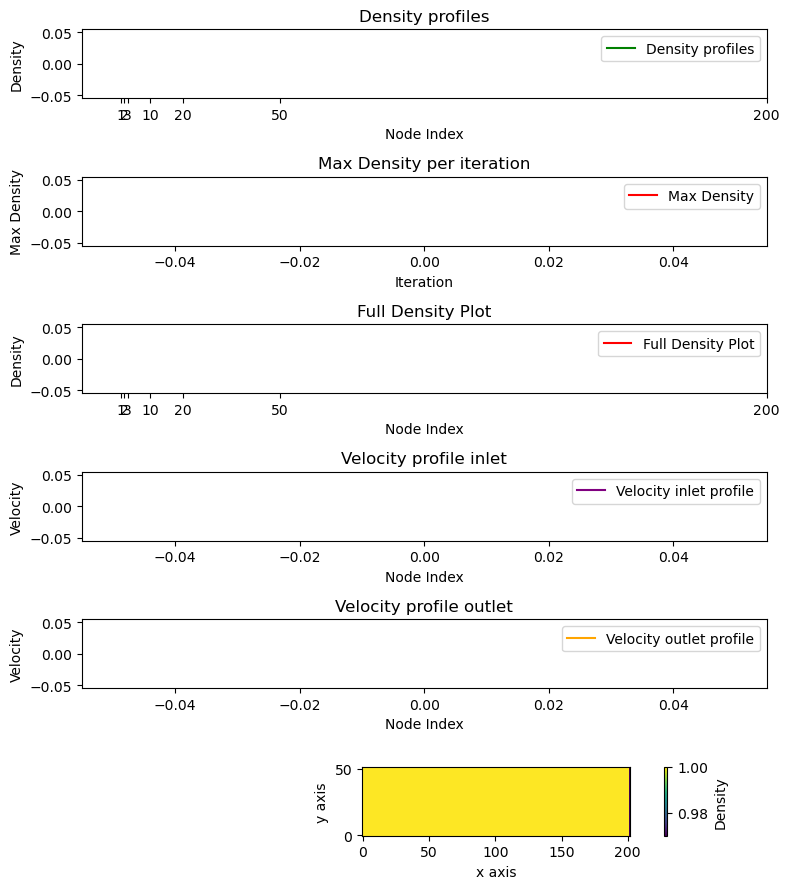

In [5]:
#preliminary
#lattice for phase space; Nx+3 is due to periodic boundary conditions
#Nx is the number of divisions in the x-direction, thus there are Nx+3 points when including the extra nodes 0 and N+1 in x-direction
#lattice columns start with 0 and end with Nx+2, X(0) = X(0) and X(N+1) = X(Nx+2)

#initialise
#average velocity, cartesion x,y-directions, k is y-position, l is x-position
t = 0
roh_in_k = np.full((Yn+2), roh_in, dtype=np.float32)
roh_out_k = np.full((Yn+2), roh_out, dtype=np.float32)
u_ckl = np.zeros((2, Yn+2, Xn+2), dtype=np.float32)
INIT_ROH = 1 #0.001
roh = np.full((Yn+2, Xn+2), INIT_ROH, dtype=np.float32)
roh[:,0] = roh_in_k
roh[:,Xn+1] = roh_out_k
#streamed_lattice = f_eq_slc(roh, u_ckl)
pdf = f_eq_3D(roh, u_ckl)


#roh = np.full((Ny, Nx+2), INIT_ROH, dtype=float)
#_roh_1 = roh[:,1]
#_roh_N = roh[:,Nx]

#1st prestreamed lattice
#prestream_lattice = f_eq_slc(0, roh, u_ckl)
#streamed_lattice = prestream_lattice.copy()
#printSelLtcPoints(index, "initialised prestream_lattice", prestream_lattice)

# Simulation parameters
num_iterations = int(TOTAL_TIME / dt) + 1
num_nodes1 = Yn #int(D/dy) + 1  # Number of nodes in inlet/outlet
R = D / 2  # Radius of the pipe
num_nodes2 = columns_to_select


#Domain decomposition
#nx = pdf.shape(1)
#ny = pdf.shape(1)
#nlocal = nx//size
#if rank == size - 1:
#    nlocal = nx - nlocal*(size-1)
#nx1 = nlocal*rank
#nx2 = nlocal*(rank+1)
#if rank == size-1:
#    nx2 = nx
#    x = np.arange(nx1-1, nx2+1)*dx


# Enable interactive mode
n = 10  # Update the graph every 10 iterations
plt.ion()
fig, ax = plt.subplots(6, 1, figsize=(8, 9))

num_x_values = roh.shape[1]
x_all = np.linspace(0, L, num_x_values)  # Example of all possible x-values
scaled_x = x_all[columns_to_select]  # Get true x-values for selected columns

#velocity_y_values = range(num_nodes1)
#velocity_y_values4Poiseuille2D = np.linspace(-R, R, num_nodes1)

#num_nodes1 = 11
velocity_y_values = range(1, Yn+1)
print("num_nodes1:")
print(num_nodes1)
print("velocity_y_values:")
print(velocity_y_values)
velocity_y_values4Poiseuille2D = get_adjusted_velocity_y_values4Poiseuille2D(num_nodes1, D)
print("velocity_y_values4Poiseuille2D:")
print(velocity_y_values4Poiseuille2D)

x_labels = [1, 2, 3, 10, 20, 50, Xn]
min_value = 0
density_max = 1.5

# Initial plots
combined_density_plot, = ax[0].plot([], [], label="Density profiles", color="green")
max_density_plot, = ax[1].plot([], [], label="Max Density", color="red")
full_density_plot, = ax[2].plot([], [], label="Full Density Plot", color="red")
velocity_inlet_plot_in, = ax[3].plot([], [], label="Velocity inlet profile", color="purple")
velocity_profile_plot_out, = ax[4].plot([], [], label="Velocity outlet profile", color="orange")


# Set titles, labels, and legends
ax[0].set_title("Density profiles")
ax[0].set_xlabel("Node Index")
ax[0].set_ylabel("Density")
ax[0].set_xticks(scaled_x)
ax[0].set_xticklabels(x_labels)
ax[0].legend()

ax[1].set_title("Max Density per iteration")
ax[1].set_ylabel("Max Density")
ax[1].set_xlabel("Iteration")
ax[1].legend()
# Fix the y-axis scale for the first plot
#ax[1].set_ylim(min_value, density_max)  # Replace min_value and max_value with your desired limits

ax[2].set_title("Full Density Plot")
ax[2].set_ylabel("Density")
ax[2].set_xlabel("Node Index")
ax[2].set_xticks(scaled_x)
ax[2].set_xticklabels(x_labels)
ax[2].legend()

ax[3].set_title("Velocity profile inlet")
ax[3].set_ylabel("Velocity")
ax[3].set_xlabel("Node Index")
ax[3].legend()

ax[4].set_title("Velocity profile outlet")
ax[4].set_ylabel("Velocity")
ax[4].set_xlabel("Node Index")
ax[4].legend()

#ax[5].figure(figsize = (15, 8))
X, Y = np.meshgrid(np.arange(0, Xn, 1), np.arange(0, Yn, 1))
im = ax[5].imshow(roh, interpolation='nearest', origin = "lower")
#cbar = ax[5].set_colorbar(im)
cbar = fig.colorbar(im, ax=ax[5])
cbar.set_label("Density")
ax[5].set_xlabel("x axis")
ax[5].set_ylabel("y axis")

plt.tight_layout()

iterations = []
maxRoh = []

In [6]:
VERBOSE = False

def updatePlots(iteration, __pdf, _u_ckl):
    __roh = np.sum(__pdf, axis=0)
    _roh_at_points_top = __roh[Yn, columns_to_select]
    _roh_at_points_mid = __roh[(Yn+2)//2, columns_to_select]
    _roh_at_points_bottom = __roh[1, columns_to_select]

    if VERBOSE:
        print(f"_roh_at_points_top: {_roh_at_points_top}")
        print(f"_roh_at_points_mid: {_roh_at_points_mid}")
        print(f"_roh_at_points_bottom: {_roh_at_points_bottom}")
    
    
    # Get the specific row from the 2D array
    row = __roh[Yn//2, :]  # Select every 100th point along the x-axis
    if VERBOSE: print(row)
    num_columns = len(row)
    # If the number of columns is more than 100, select 100 evenly spaced points
    if num_columns > 100:
        # Generate 100 evenly spaced indices
        indices = np.linspace(0, num_columns - 1, 100, dtype=int)
        if VERBOSE: 
            print("indices:")
            print(indices)
        density_y = row[indices]
        density_x = np.linspace(0, __roh.shape[1], len(density_y), dtype=int)
    else:
        # If there are fewer than 100 points, return the whole row
        density_y = row
        density_x = np.linspace(0, __roh.shape[1], len(row), dtype=int)
        
   
    maxRoh.append(np.max(__roh))
    iterations.append(iteration)
    if len(_roh_at_points_top) > 0:

        # Redraw the plot with new data
        ax[0].cla()  # Clear the current axis (combined density plot)        
        ax[0].plot(scaled_x, _roh_at_points_top, label="Density Top", color="green")
        ax[0].plot(scaled_x, _roh_at_points_mid, label="Density Mid", color="blue")
        ax[0].plot(scaled_x, _roh_at_points_bottom, label="Density Bottom", color="purple")
    
        # Set titles, labels, and legends again after clearing the axis
        ax[0].set_title("Density Profiles (Top, Mid, Bottom)")
        ax[0].set_xlabel("Node Index")
        ax[0].set_ylabel("Density")
        ax[0].set_xticks(scaled_x)
        ax[0].set_xticklabels(x_labels)
        ax[0].legend()
        # Get the maximum value from the current data and set y-limits with a gap of 20%
        max_y_value = max(np.max(_roh_at_points_top), np.max(_roh_at_points_mid), np.max(_roh_at_points_bottom))
        # Set the y-axis limits
        ax[0].set_ylim(0, max_y_value * 1.2)  # Add a gap of 20% above the maximum value
        

        if VERBOSE: 
            print(f"iterations: {iterations}")
            print(f"maxRoh: {maxRoh}")
        ax[1].cla()
        ax[1].plot(iterations, maxRoh, label="Max density per iteration", color="red")        
        ax[1].set_title("Max Density per iteration")
        ax[1].set_ylabel("Max Density")
        ax[1].set_xlabel("Iteration")


        ax[2].cla()
        ax[2].plot(density_x, density_y, label="Longitudinal density profile", color="blue")        
        ax[2].set_title("Longitudinal density profile")
        ax[2].set_ylabel("Density")
        ax[2].set_xlabel("Node Index")
        ax[2].set_ylim(0, max_y_value * 1.2)  # Add a gap of 20% above the maximum value

        
        # Add the Poiseuille velocity profile to ax[3]
        U = np.max(_u_ckl[0,:,1])
        poiseuille_velocities = np.array([Poiseuille2DUy2(y, U, D) for y in velocity_y_values4Poiseuille2D])  # Get velocity profile
        ax[3].cla()  # Clear the previous plot on ax[3]
        ax[3].plot(velocity_y_values, u_ckl[0, 1:Yn+1, 1], label="Numerical velocity profile - inlet", color="purple")
        ax[3].plot(velocity_y_values, poiseuille_velocities, label="Analytical Poiseuille profile - inlet", color="red", linestyle="--")
        ax[3].set_title("Velocity profile inlet")
        #ax[3].set_xticks(velocity_y_values)
        ax[3].set_xlabel("Node Index")
        ax[3].set_ylabel("Velocity")
        ax[3].legend()

        
        # Add the Poiseuille velocity profile to ax[4]
        U = np.max(_u_ckl[0,:,Xn])
        poiseuille_velocities = np.array([Poiseuille2DUy2(y, U, D) for y in velocity_y_values4Poiseuille2D])  # Get velocity profile
        ax[4].cla()  # Clear the previous plot on ax[3]
        ax[4].plot(velocity_y_values, u_ckl[0, 1:Yn+1, Xn], label="Numerical velocity profile - outlet", color="orange")
        ax[4].plot(velocity_y_values, poiseuille_velocities, label="Analytical Poiseuille profile - outlet", color="red", linestyle="--")
        ax[4].set_title("Velocity profile outlet")
        ax[4].set_xlabel("Node Index")
        ax[4].set_ylabel("Velocity")
        ax[4].legend()


        ax[5].cla()
        X, Y = np.meshgrid(np.arange(0, Xn, 1), np.arange(0, Yn, 1))
        im = ax[5].imshow(__roh, interpolation='nearest', origin = "lower")

        
        del _u_ckl
        gc.collect()

        # Adjust plot limits dynamically
        for i, axis in enumerate(ax):
            axis.relim()
            axis.autoscale_view()

        # Redraw the entire figure canvas to prevent blank areas
        clear_output(wait=True)
        display(fig)

        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)  # Adjust these values as needed

        # Pause to allow plot to update
        plt.pause(0.1)    

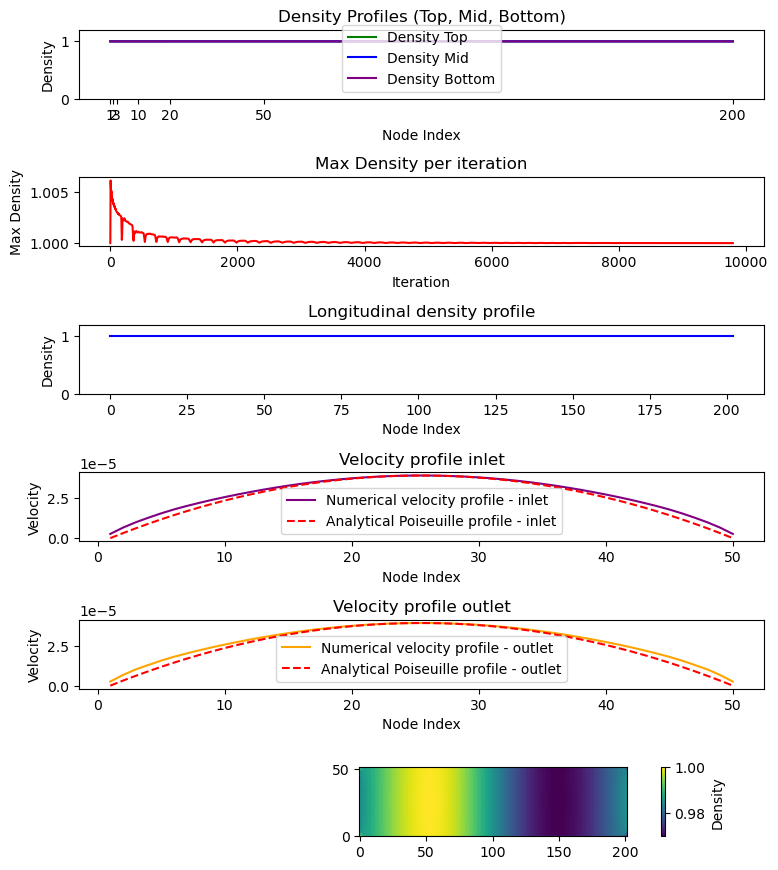

<Figure size 640x480 with 0 Axes>

In [ ]:
while t < TOTAL_TIME:
    print("\n\nindex: {0} ------------------------------------------------".format(iteration))

    #1. moment update
    if iteration > 0:
        roh, u_ckl = updateMoments(pdf)
        #override the densities at 0 and N+1 using ideal gas law in isothermal ﬂuid ﬂow
        # p = cs**2 * roh 
    #enforce densities at boundary points and inlet and outlet
    #roh[:, 0] = roh_in
    #roh[:, Xn+1] = roh_out

    # Get the maximum density and its location
    max_density = np.max(roh)
    max_location = np.unravel_index(np.argmax(roh), roh.shape)
    if np.any(roh > 1):
        print(f"Instability detected at iteration {iteration + 1}")
    print(f"Maximum density: {max_density} at location {max_location}")

    #2. compute equilibrium
    f_eq = f_eq_3D(roh, u_ckl)

    #3. collision term
    pdf = pdf * (1 - omega_nd) + omega_nd * f_eq
    del f_eq
    gc.collect()

    #4.1a Periodic Boundary conditions inlet/outlet with pressure difference
    #update extra node layers 0 and N+1 -> A) & B) acc. to Script: Boundary Conditions for the Lattice Boltzmann Method
    u_cNl = u_ckl[:, :, Xn]
    u_c1l = u_ckl[:, :, 1]   
    #u_ckl profiles at outlet and inlet
    _roh_k1 = roh[:, 1]  
    _roh_kN = roh[:, Xn]    
    #assign inlet and outlet boundary values -> A)    
    fi_x0, fi_xNplus1 = calcPeriodicBC(_roh_kN, u_cNl, roh_in_k, _roh_k1, u_c1l, roh_out_k, pdf)

    #5. stream lattice 
    #store pre-stream boundary top and bottom values
    _ltc_pre = pdf.copy()
    pdf = streamLattice(pdf)

    #4.2 Bounce-Back Top and Bottom
    #pdf = bounceBackTopBottom0(pdf, _ltc_pre, index_mapping_top, index_mapping_bottom)
    pdf = bounceBackTopBottom1(pdf, Xn, Yn)
    del _ltc_pre
    gc.collect()

    #4.1b. assign inlet boundary values -> B)
    pdf[:, :, 0] = fi_x0

    # Update plots
    updatePlots(iteration, pdf, u_ckl)

    t += dt
    iteration += 1
    print(f"Simulation Execution -> TOTAL_TIME: {TOTAL_TIME}; t: {t}; %: {(t/TOTAL_TIME)*100.0}")
    gc.collect()

# Turn off interactive mode and display the final plot
plt.ioff()
plt.show()